In [1]:
#!pip install imblearn
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
from scipy.stats import ttest_1samp, wilcoxon, mannwhitneyu

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.metrics import classification_report_imbalanced

In [3]:
conn = MongoClient('140.115.53.147', 27017)
conn.database_names()

['107_ELK',
 'AU_106_2_BIO',
 'AU_106_2_SE',
 'CYCU_1031SP',
 'CYCU_1032OS',
 'CYCU_1041SP',
 'CYCU_1042OS',
 'CYCU_1051SP',
 'CYCU_1052OS',
 'KU_dataset_1',
 'KU_dataset_2',
 'NCU_1071MATH',
 'NCU_CHKA',
 'NCU_CHKB',
 'NCU_ETS',
 'NCU_FC',
 'NCUx107_Pre_college_calculas',
 'OULAD',
 'admin',
 'config',
 'local',
 'test']

In [4]:
datasets = 'KU_dataset_1'
db = conn[datasets]
collection = db['data1_score.csv']
score_df = pd.DataFrame(list(collection.find()))
score_df = score_df.drop(['_id'], axis=1)
#score_df = df['final_score']
#score_df = score_df.dropna()
#score_df = score_df['final_score'].astype(float)
score_df.head(5)

,score,userid
0,80,ds101
1,80,ds102
2,60,ds103
3,50,ds104
4,100,ds105


In [5]:
db = conn[datasets]
collection = db['data1_15features.csv']
feature_df = pd.DataFrame(list(collection.find()))
feature_df = feature_df.drop(['_id', 'label_2'], axis=1)

feature_df = feature_df.fillna('0')
feature_df.rename(index=str, columns={"Userid": "userid"}, inplace=True)
#feature_df = df['final_score']
#feature_df = score_df.dropna()
#feature_df = feature_df.astype(float)

#feature_df = feature_df.groupby(['username']).mean()
feature_df.head(5)

,Add_Bookmark,Add_Marker,Add_Memo,Change_Memo,Close,Delete_Bookmark,Delete_Marker,Delete_Memo,Jump,Marker,Memo,Next,Open,Prev,Score,Search,userid,class
0,0,0,0,0,0,0,0,0,0,0,0,1186,8,756,100,0,ds108,1
1,0,0,0,0,3,0,0,0,4,0,0,278,10,66,60,0,ds109,0
2,1,1,1,0,0,1,1,0,2,2,2,48,4,29,50,0,ds104,0
3,0,0,0,0,0,0,0,0,0,0,0,5,1,2,80,0,ds102,1
4,0,0,0,0,6,0,0,0,2,0,0,766,10,79,75,0,ds110,0


In [6]:
ncu_ets = pd.merge(feature_df, score_df, on='userid')
ncu_ets = ncu_ets.drop(['userid'], axis=1)
#ncu_ets = ncu_ets.drop(['week'], axis=1)
ncu_ets = ncu_ets.astype(float)
ncu_ets['class'] = ncu_ets['score'] < 60
ncu_ets = ncu_ets.drop(['score'], axis=1)
ncu_ets.head(5)

,Add_Bookmark,Add_Marker,Add_Memo,Change_Memo,Close,Delete_Bookmark,Delete_Marker,Delete_Memo,Jump,Marker,Memo,Next,Open,Prev,Score,Search,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,8.0,756.0,100.0,0.0,False
1,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,278.0,10.0,66.0,60.0,0.0,False
2,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,48.0,4.0,29.0,50.0,0.0,True
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,2.0,80.0,0.0,False
4,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,2.0,0.0,0.0,766.0,10.0,79.0,75.0,0.0,False


In [7]:
X = ncu_ets.drop(['class'], axis=1)
X = X.values
y = ncu_ets['class']

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

clf_binary = svm.SVC(kernel='rbf', 
                     probability=True,
                     cache_size=700,
                     random_state=5)

clf_one = svm.OneClassSVM(kernel="rbf",
                         cache_size=700,
                        random_state=5)

In [8]:
def compute_roc (X, y, title):
    
    tprs = []
    aucs = []
    #acc = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    #fig, ax1 = plt.su
    
    i = 0
    for train, test in cv.split(X, y):

        y_pred = clf_binary.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], y_pred[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        acc = accuracy_score(y[test], y_pred[:, 1].round())
        precision, recall, _ = precision_recall_curve(y[test], y_pred[:, 1])
        average_precision = average_precision_score(y[test], y_pred[:, 1])
        #accs.append(accuracy_score(y[test], y_pred[:, 1].round()))
        ax1.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f, ACC = %0.2f)' % (i, roc_auc, acc))

        i += 1
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic of '+ title)
    ax1.legend(loc="lower right")
    
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    ax2.step(recall, precision, color='b', alpha=0.2, where='post')
    ax2.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    ax2.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    image_name = './images/' + datasets + '_' + title + '.png'
    fig.savefig(image_name, dpi=300)
    
    return aucs

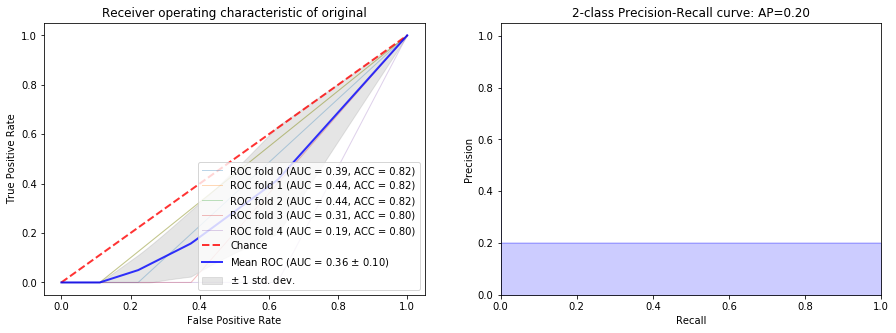

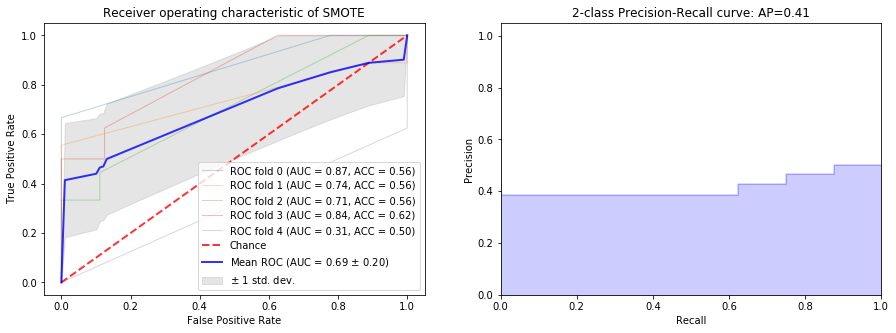

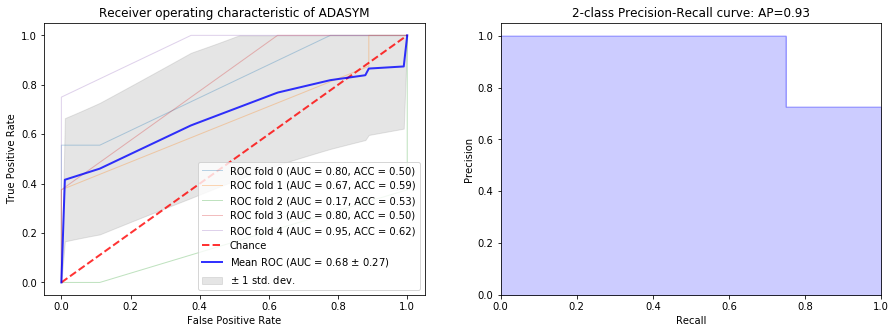

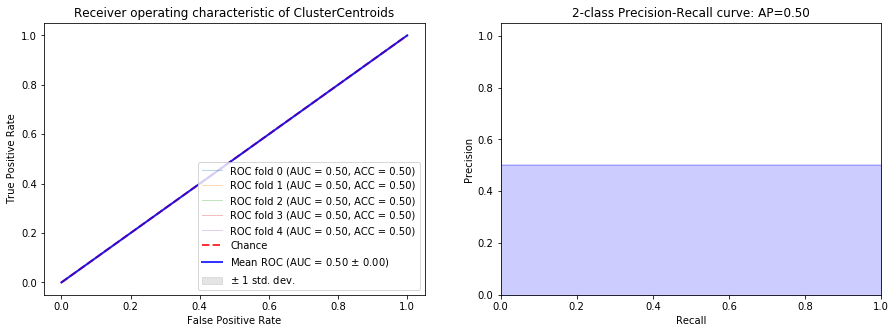

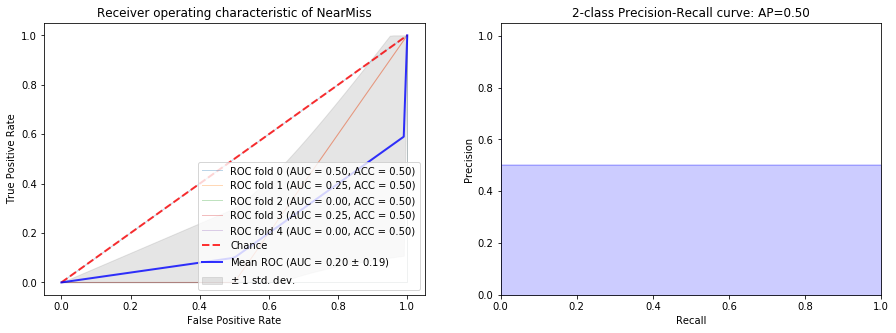

In [9]:
auc_ori = compute_roc(X, y, title='original')

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
auc_sm = compute_roc(res_X, res_y, title='SMOTE')

res_X, res_y = ADASYN(ratio = 1.0).fit_sample(X, y)
auc_ada = compute_roc(res_X, res_y, title='ADASYM')

res_X, res_y = ClusterCentroids(random_state=0).fit_sample(X, y)
auc_cc = compute_roc(res_X, res_y, title='ClusterCentroids')

res_X, res_y = NearMiss(random_state=0).fit_sample(X, y)
auc_nm = compute_roc(res_X, res_y, title='NearMiss')

In [10]:
u, p_value = mannwhitneyu(auc_ori, auc_sm)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_ada)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_cc)
print ("two-sample wilcoxon-test", p_value)

u, p_value = mannwhitneyu(auc_ori, auc_nm)
print ("two-sample wilcoxon-test", p_value)

two-sample wilcoxon-test 0.0370130445789652
two-sample wilcoxon-test 0.07122834869704933
two-sample wilcoxon-test 0.003645179045767819
two-sample wilcoxon-test 0.14592027257189422


In [11]:
y_pred = clf_binary.fit(X, y).predict_proba(X)

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
y_pred_res = clf_binary.fit(res_X, res_y).predict_proba(X)

In [12]:
temp_pd = ncu_ets
temp_pd['original'] = y_pred[:, 1].round()
temp_pd['smote'] = y_pred_res[:, 1].round()
temp_pd.head(5)

,Add_Bookmark,Add_Marker,Add_Memo,Change_Memo,Close,Delete_Bookmark,Delete_Marker,Delete_Memo,Jump,Marker,Memo,Next,Open,Prev,Score,Search,class,original,smote
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,8.0,756.0,100.0,0.0,False,1.0,0.0
1,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,278.0,10.0,66.0,60.0,0.0,False,1.0,0.0
2,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,48.0,4.0,29.0,50.0,0.0,True,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,2.0,80.0,0.0,False,1.0,0.0
4,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,2.0,0.0,0.0,766.0,10.0,79.0,75.0,0.0,False,1.0,0.0


In [13]:
origin_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]
smote_pd = temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]

<Figure size 1080x1080 with 0 Axes>

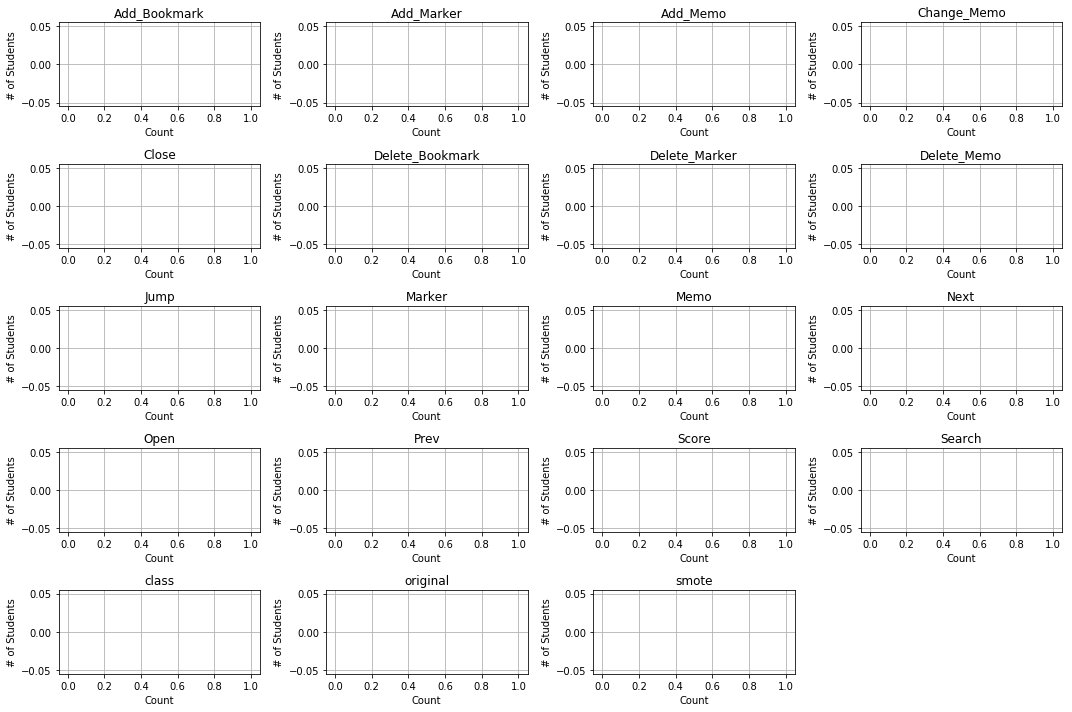

In [14]:
plt.figure(figsize=(15, 15))
ax = origin_pd.hist(alpha=0.8, bins=15, figsize=(15, 10))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'fc_original' + '.png'
plt.savefig(image_name, dpi=300)

<Figure size 1080x1080 with 0 Axes>

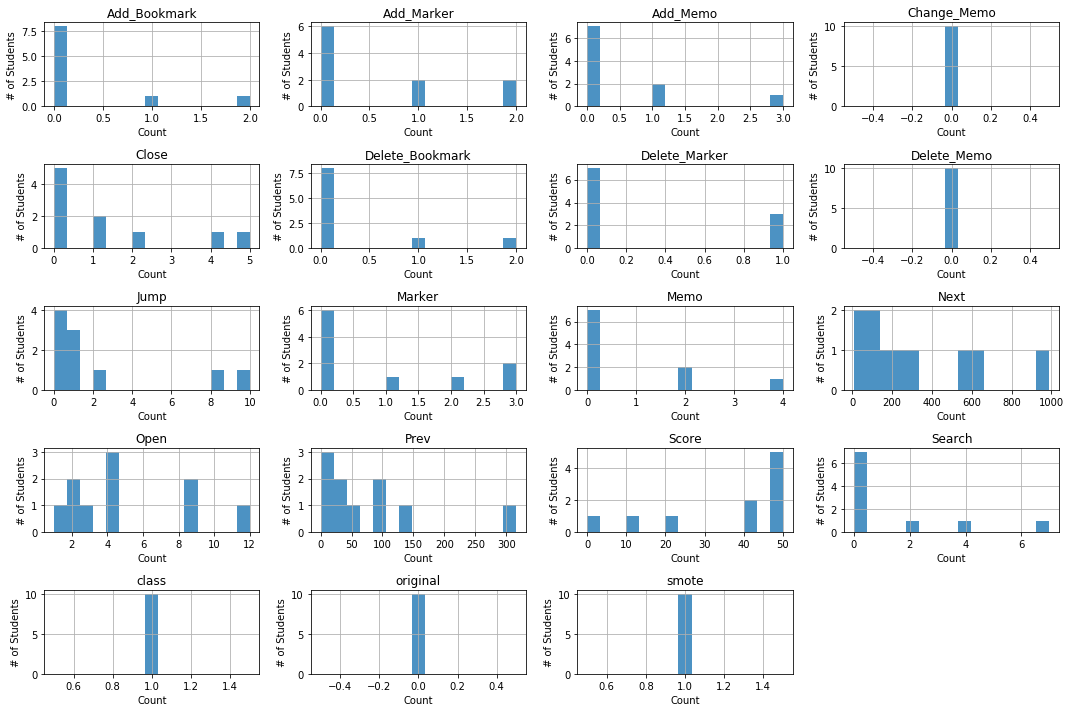

In [15]:
plt.figure(figsize=(15, 15))
ax = smote_pd.hist(alpha=0.8, bins=15, figsize=(15, 10))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
image_name = './images/' + datasets + '_' + 'fc_smote' + '.png'
plt.savefig(image_name, dpi=300)

In [16]:
print(len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]))
print(len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]))
print(len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 0.0)]))
print(len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 1.0)]))



0
10
0
0


In [17]:
print(len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)]))
print(len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)]))
print(len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 0.0)]))
print(len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 1.0)]))

0
0
43
0


Type1: risk students been misidenfied (nop)

Type2: risk students been misidenfied, but fixed by resample (good)

Type3: risk students been identified, but misidentified by resample (bad)

Type4: risk students been identified (nop)

Type5: non-risk students been identified (nop)

Type6: non-risk students been identified, but misidentified by resample (bad)

Type7: non-risk students been misidentified, but fixed by resample (good)

Type8: non-risk students been misidentified (nop) {{a}}

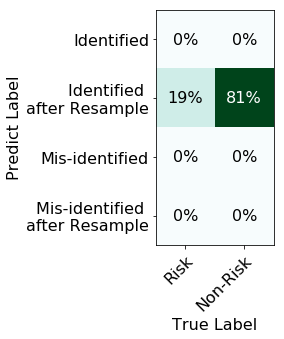

<Figure size 432x288 with 0 Axes>

In [18]:
plt.rcParams.update({'font.size': 16})

vegetables = ["Identified", 
              "Identified \nafter Resample", 
              "Mis-identified",
              "Mis-identified \nafter Resample"]
farmers = ["Risk", "Non-Risk"]

#risk
T1 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)])
T2 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)])
T3 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 0.0)])
T4 = len(temp_pd.ix[(temp_pd['class']==True) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 1.0)])
#non-risk
T5 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 0.0)])
T6 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 0.0) & (temp_pd['smote'] == 1.0)])
T7 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 0.0)])
T8 = len(temp_pd.ix[(temp_pd['class']==False) & (temp_pd['original'] == 1.0) & (temp_pd['smote'] == 1.0)])

harvest = np.array([[T4, T5],
                    [T2, T7],
                    [T1, T8],
                    [T3, T6]])

#plt.style.use('classic')
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(harvest, cmap=plt.cm.BuGn)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        if (harvest[i, j]) > 40: 
            color='white'
        else:
            color='black'    
        text = ax.text(j, i, "{0:.0%}".format(harvest[i, j] / harvest.sum()),
                       ha="center", va="center", color=color)

#ax.set_title("Harvest of local farmers (in tons/year)")
ax.set_xlabel("True Label")
ax.set_ylabel("Predict Label")

#plt.colorbar()
#cb.set_label('mean value')
fig.tight_layout()
plt.show()

image_name = './images/' + datasets + '_' + 'c_matrix' + '.png'
plt.savefig(image_name, dpi=300)

In [19]:
datasets

'KU_dataset_1'